# Fit classifier

## Background

We use a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) to map crop type. 

The [`scikit-learn`](https://scikit-learn.org/stable/) Python libary
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. A number of hyperparameters can be tuned for this classifier.  

implemented in the [`scikit-learn`](https://scikit-learn.org/stable/) Python libary.


The [`scikit-learn`](https://scikit-learn.org/stable/) library provides a number of functionalities 

## Description

We fit a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) implemented in the [`scikit-learn`](https://scikit-learn.org/stable/) Python libary.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.



## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import json
import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from odc.io.cgroups import get_cpu_quota
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    cross_validate,
)
from sklearn import model_selection
from sklearn.metrics import  accuracy_score,confusion_matrix,precision_score, recall_score

## Read in training data and label dictionary

### Define the data and label paths

In [2]:
# Training data file from previous step
data_path = "Results/single_crops_merged_training_features_2021_selected.csv"

# Dictionary with class labels from previous step
labels_path = "Results/class_labels.json"

### Load the data and identify the feature columns for the model

In [ ]:
model_input_df = pd.read_csv(data_path)

# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

Label column:
label

Feature columns:
['blue_s2_Q4_2021', 'green_s2_Q4_2021', 'red_s2_Q4_2021', 'nir_s2_Q4_2021', 'swir_1_s2_Q4_2021', 'swir_2_s2_Q4_2021', 'red_edge_1_s2_Q4_2021', 'red_edge_2_s2_Q4_2021', 'red_edge_3_s2_Q4_2021', 'NDVI_s2_Q4_2021', 'LAI_s2_Q4_2021', 'SAVI_s2_Q4_2021', 'MSAVI_s2_Q4_2021', 'MNDWI_s2_Q4_2021', 'blue_s2_Q1_2022', 'green_s2_Q1_2022', 'red_s2_Q1_2022', 'nir_s2_Q1_2022', 'swir_1_s2_Q1_2022', 'swir_2_s2_Q1_2022', 'red_edge_1_s2_Q1_2022', 'red_edge_2_s2_Q1_2022', 'red_edge_3_s2_Q1_2022', 'NDVI_s2_Q1_2022', 'LAI_s2_Q1_2022', 'SAVI_s2_Q1_2022', 'MSAVI_s2_Q1_2022', 'MNDWI_s2_Q1_2022', 'blue_s2_Q2_2022', 'green_s2_Q2_2022', 'red_s2_Q2_2022', 'nir_s2_Q2_2022', 'swir_1_s2_Q2_2022', 'swir_2_s2_Q2_2022', 'red_edge_1_s2_Q2_2022', 'red_edge_2_s2_Q2_2022', 'red_edge_3_s2_Q2_2022', 'NDVI_s2_Q2_2022', 'LAI_s2_Q2_2022', 'SAVI_s2_Q2_2022', 'MSAVI_s2_Q2_2022', 'MNDWI_s2_Q2_2022', 'blue_s2_Q3_2022', 'green_s2_Q3_2022', 'red_s2_Q3_2022', 'nir_s2_Q3_2022', 'swir_1_s2_Q3_2022', '

In [4]:
labels_dict

{'Maize': 0, 'Others': 1, 'Sesame': 2, 'Soy': 3}

## Fit, tune and evaluate multiple models using nested cross-validation

This step allows us to train and tune mutliple models on fixed subsets of our data.

When performing cross validation, data is split into `n` folds. One fold is kept aside as test data, and the rest is used to train a model. This step is repeated until each fold has been used as a test set, having been trained on the other folds. From each fold, we get an estimate of the performance, which can be averaged to understand expected performance of a model on unseen data.

### Get number of cpus available

In [9]:
ncpus = round(get_cpu_quota())
print("ncpus = " + str(ncpus))

ncpus = 62


## Grid search to find optimal random forest classifier hyperparameters

In [12]:
rf_param_grid = {
    "class_weight": ["balanced", None],
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [200, 300, 400],
    "criterion": ["gini", "entropy"],
}

In [13]:
cv=model_selection.StratifiedShuffleSplit(n_splits=5,random_state=1) # stratified shuffle K-fold splitting
rf = RandomForestClassifier()
print('Grid searching best hyper-parameters...')
grid_search=model_selection.GridSearchCV(estimator = rf,param_grid=rf_param_grid,cv=cv,n_jobs=ncpus)
grid_search.fit(X_dropped,y)
print('Optimal parameters: \n',grid_search.best_params_)
rf = RandomForestClassifier(**grid_search.best_params_, random_state=1, n_jobs=ncpus)

Grid searching best hyper-parameters...
Optimal parameters: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}


In [14]:
rf.fit(X_dropped,y)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=62,
                       random_state=1)

most importance features: 
 Index(['emad_s2_semiannual_2021_07', 'emad_s2_annual_2021',
       'red_edge_1_s2_semiannual_2022_01', 'npv_mean_Q4_2021',
       'red_edge_1_s2_annual_2021', 'ue_mean_Q4_2021',
       'blue_s2_semiannual_2021_07', 'MNDWI_s2_Q3_2022', 'ue_mean_Q3_2022',
       'red_edge_1_s2_Q1_2022'],
      dtype='object')


Text(0.5, 0, 'Variable')

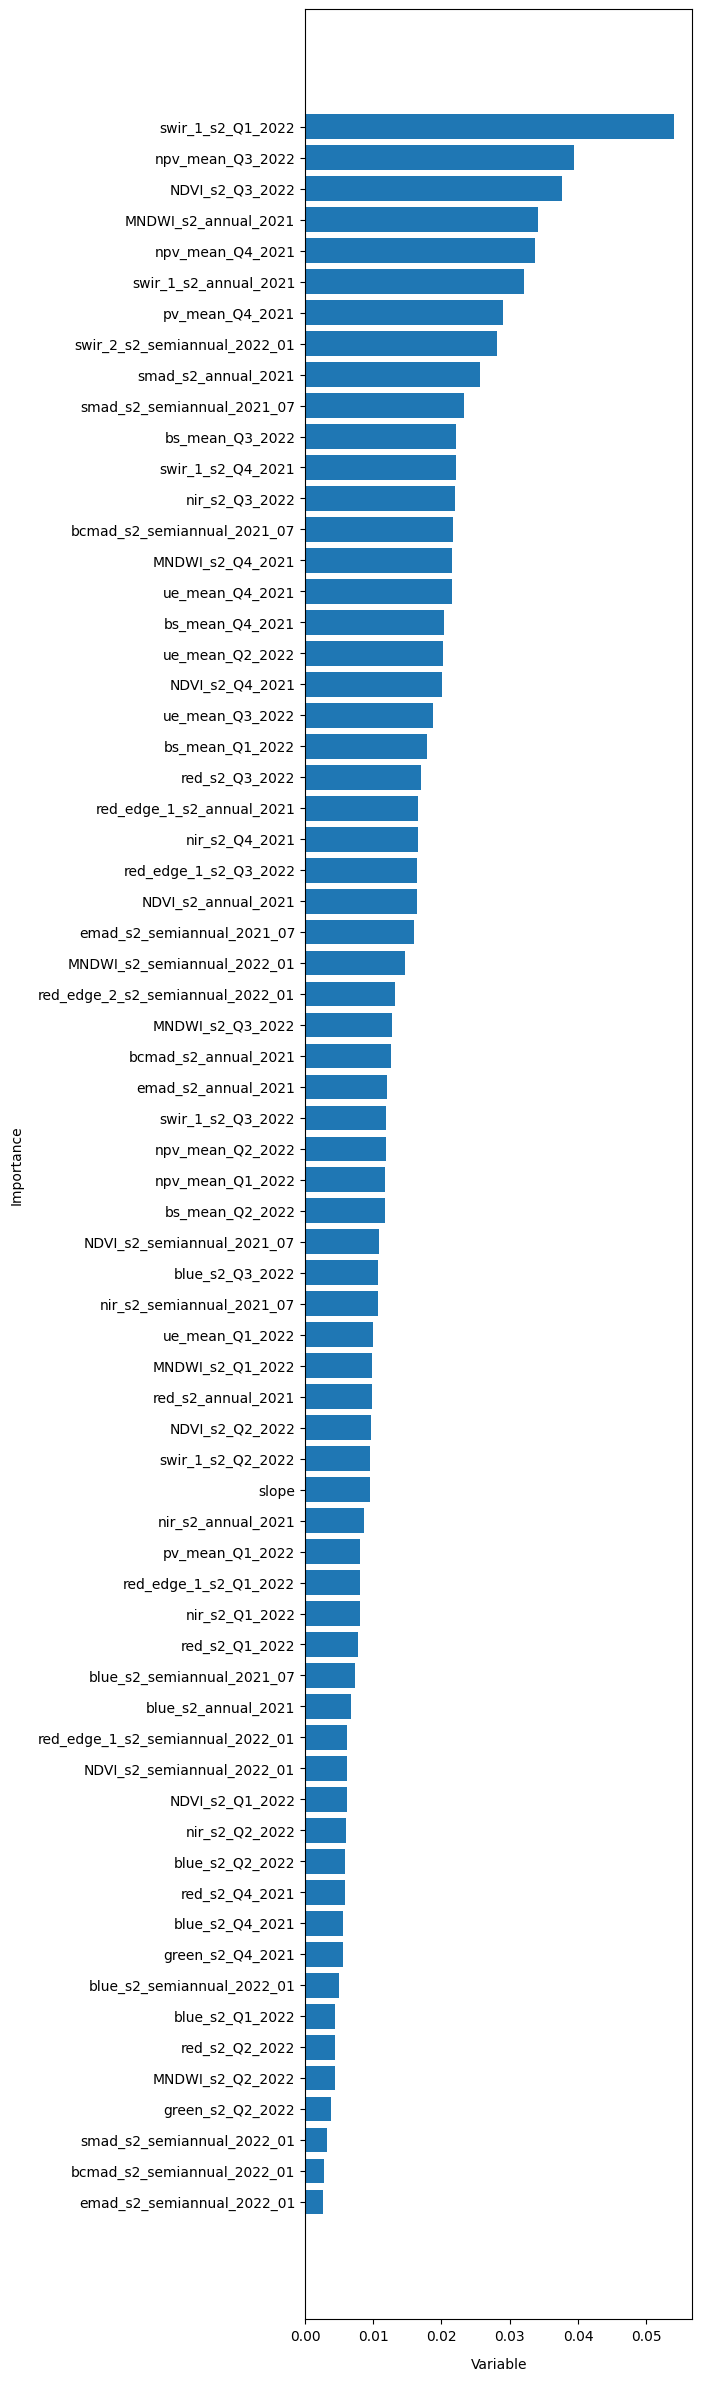

In [15]:
# most important features
feat_importance_indices=np.argsort(rf.feature_importances_)[-10:]
print('most importance features: \n',X_dropped.columns[1:][feat_importance_indices])
plt.figure(figsize=(5,30))
order=np.argsort(rf.feature_importances_)
plt.barh(y=np.array(X_dropped.columns)[order],width=rf.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10)

## Accuracy assessment

In [16]:
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # stratified K-fold splitting
# skf=model_selection.StratifiedKFold(n_splits=5,shuffle=False) # stratified K-fold splitting
overall_acc=model_selection.cross_val_score(rf,X_dropped,y,cv=skf,scoring='accuracy')
print('Overall accuracy from cv scores: ',np.mean(overall_acc))
f1_macro=model_selection.cross_val_score(rf,X_dropped,y,cv=skf,scoring='f1_macro')
print('f1_macro from cv scores: ',np.mean(f1_macro))

Overall accuracy from cv scores:  0.9942275042444821
f1_macro from cv scores:  0.9940343243908994


In [17]:
values=list(labels_dict.values())
predictions=model_selection.cross_val_predict(rf,X_dropped,y,cv=skf)
precision=precision_score(y,predictions,labels=values,average=None)
print('Precision for each class: \n',dict(zip([key for key in labels_dict.keys()],np.around(precision,3))))

Precision for each class: 
 {'Maize': 0.992, 'Others': 0.998, 'Sesame': 0.991, 'Soy': 1.0}


In [18]:
recall=recall_score(y,predictions,labels=values,average=None)
print('Recall for each class: \n',dict(zip([key for key in labels_dict.keys()],np.around(recall,3))))

Recall for each class: 
 {'Maize': 0.997, 'Others': 0.993, 'Sesame': 0.993, 'Soy': 0.989}


Confusion matrix:



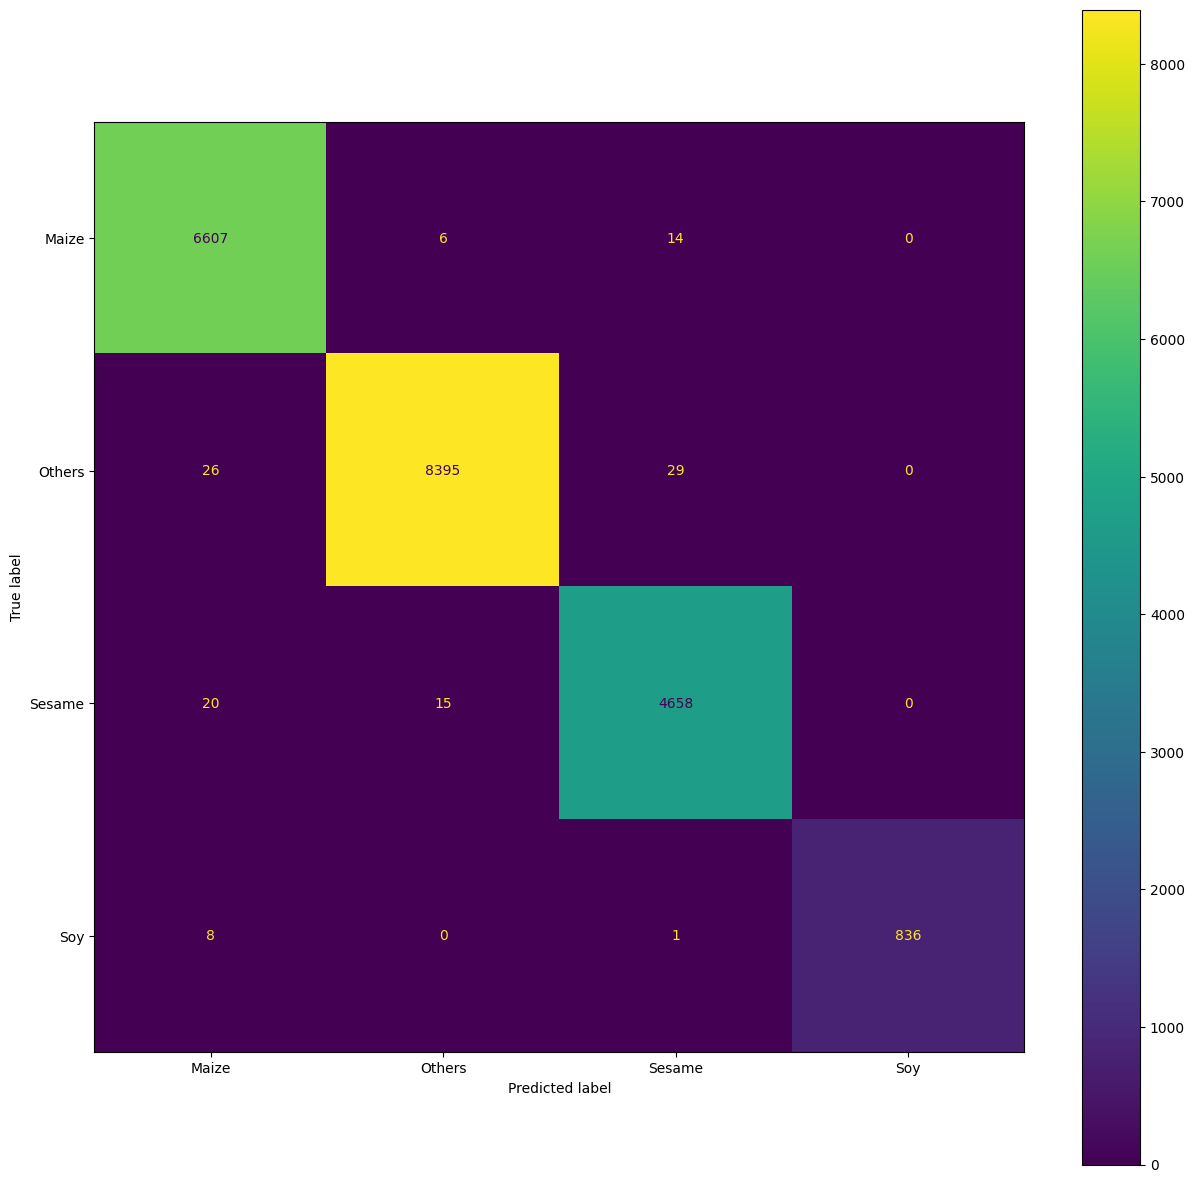

In [19]:
cm=confusion_matrix(y, predictions)
display_labels=[list(labels_dict.keys())[list(labels_dict.values()).index(i)] for i in rf.classes_]
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
print('Confusion matrix:\n')
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

In [20]:
# fit classifier using all samples and the optimised hyperparameters
dump(rf, f"results/{experiment_name}.joblib")

# Export the columns to use in the final model
with open(f"results/{experiment_name}_features.json", "w", encoding="utf-8") as f:
    json.dump({"features": list(X_dropped.columns)}, f, ensure_ascii=False, indent=4)